In [1]:
import string
import pandas as pd
import numpy as np

import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from itertools import product

# 6.1 Logic Definition of Generalization:
##### a) Show empirically that the information limit of 2 prediction bits per parameter also holds for nearest neighbors.
We do this via recursion. We see the numbers tend around 2.

In [2]:
def iteratively_remove_rows(X, y, original_X, original_y):
    if X.shape[0] <= 1:
        return X, y

    for i in range(X.shape[0]):
        X_train = X.drop(X.index[i])
        y_train = y.drop(y.index[i])

        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(original_X)
        accuracy = accuracy_score(original_y, y_pred)

        if accuracy == 1:
            return iteratively_remove_rows(X_train, y_train, original_X, original_y)

    return X, y

In [3]:
sizes_and_repeats = [(16, 2), (32, 4), (64, 8)]
for size, repeat in sizes_and_repeats:
    y_sizes = []
    for _ in range(size):
        X = np.array(list(product([0, 1], repeat=repeat)))
        N, _ = X.shape
        y = np.random.randint(2, size=(X.shape[0], 1)).ravel()
        X = pd.DataFrame(X)
        y = pd.Series(y)
        X_fin, y_fin = iteratively_remove_rows(X, y, X, y)
        y_sizes.append(len(y_fin))
    mean_size = np.mean(y_sizes)
    print(f"d={repeat}: n_full={2**repeat}, Avg. req. points for memorization n_avg={mean_size:.2f}, n_avg/d={2**repeat/mean_size:.2f}")

d=2: n_full=4, Avg. req. points for memorization n_avg=2.69, n_avg/d=1.49
d=4: n_full=16, Avg. req. points for memorization n_avg=8.31, n_avg/d=1.92
d=8: n_full=256, Avg. req. points for memorization n_avg=162.06, n_avg/d=1.58


#####  b) Extend your experiments to multi-class classification.
Now they tend to 1.5.

In [4]:
sizes_and_repeats = [(16, 2), (32, 4), (64, 8)]

for size, repeat in sizes_and_repeats:
    y_sizes = []
    for _ in range(size):
        X = np.array(list(product([0, 1], repeat=repeat)))
        N, _ = X.shape
        y = np.random.randint(3, size=(X.shape[0], 1)).ravel()
        X = pd.DataFrame(X)
        y = pd.Series(y)
        X_fin, y_fin = iteratively_remove_rows(X, y, X, y)
        y_sizes.append(len(y_fin))
    mean_size = np.mean(y_sizes)
    print(f"d={repeat}: n_full={2**repeat}, Avg. req. points for memorization n_avg={mean_size:.2f}, n_avg/d={2**repeat/mean_size:.2f}")

d=2: n_full=4, Avg. req. points for memorization n_avg=2.81, n_avg/d=1.42
d=4: n_full=16, Avg. req. points for memorization n_avg=11.03, n_avg/d=1.45
d=8: n_full=256, Avg. req. points for memorization n_avg=195.69, n_avg/d=1.31


# 6.2 Finite State Machine Generalization
##### a) Implement a program that automatically creates a set of if-then clauses from the training table of a binary dataset of your choice. Implement different strategies to minimize the number of if-then clauses. Document your strategies, the number of resulting conditional clauses, and the accuracy achieved.

First I implement Algorithm 8 from the textbook in its original form.

In [5]:
def memorize(data, labels):
    thresholds = 0
    n, d = data.shape
    table = np.zeros((n, 2))
    
    for row in range(n):
        table[row, 0] = np.sum(data[row, :])
        table[row, 1] = labels[row]
    
    sorted_table = table[table[:, 0].argsort()]
    current_class = sorted_table[0, 1]
    
    for row in range(n):
        if sorted_table[row, 1] != current_class:
            current_class = sorted_table[row, 1]
            thresholds += 1
    
    minthreshs = np.log2(thresholds + 1)
    mec = (minthreshs * (d + 1)) + (minthreshs + 1)
    return mec

Check implementation on known dataset (AND logic gate).

In [6]:
test_and = np.array([[0,1,0],[1,0,0], [1,1,1], [0,0,0]])
memorize(test_and[:, 0:-1], test_and[:, -1])

5.0

Now use Algorithm 8 to create our basic set of if then clauses and test on AND.

In [7]:
def if_then_clauses(data, labels):
    clauses = []
    n, d = data.shape
    
    df = pd.DataFrame(data).copy()
    df['sum'] = data.sum(axis=1)
    df['label'] = labels 
    sorted_table = df.sort_values(by='sum').reset_index(drop=True)

    current_class = sorted_table.iloc[0, -1]

    for row in range(n):
        row_sum = sorted_table.iloc[row, -2]
        if sorted_table.iloc[row, -1] != current_class:
            current_class = sorted_table.iloc[row, -1]
            conditions = ["X{}={}".format(idx, value) for idx, value in enumerate(sorted_table.iloc[row, :-2])]
            clause = "IF sum >= {} THEN class={}".format(row_sum, current_class)
            clauses.append(clause)
    
    return clauses

In [8]:
# Check output using AND dataset
if_then_clauses(test_and[:, 0:-1], test_and[:, -1])

['IF sum >= 2 THEN class=1']

Generate predictions and accuracy using if_then_clauses.

In [9]:
def predict_if_then(X, y):
    predictions = []
    
    X = pd.DataFrame(X)
    y = pd.Series(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)
    
    clauses = if_then_clauses(X_train, y_train)

    for row in range(X_test.shape[0]):
        row_sum = X_test.iloc[row].sum()
        predicted_class = y_train.iloc[0] #Copy from algo 8, set first class as default

        for clause in clauses:
            parts = clause.split(" THEN ")
            sum_threshold = float(parts[0].split(" >= ")[1])
            clause_class = parts[1].replace("class=", "")

            if row_sum >= sum_threshold:
                predicted_class = int(clause_class)
        
        predictions.append(predicted_class)
        
    accuracy = accuracy_score(y_test, np.array(predictions))
    return predictions, accuracy, clauses

The above algorithm is optimal assuming the weights are zero. Now use gradient descent to optimise in case the weights are not 0.

In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def update_weights(X, y, weights, learning_rate):
    predictions = sigmoid(np.dot(X, weights))
    gradient = np.dot(X.T, (predictions - y)) / len(y)
    weights -= learning_rate * gradient
    return weights

def predict(X, weights):
    probabilities = sigmoid(np.dot(X, weights))
    return [1 if prob >= 0.5 else 0 for prob in probabilities]

def evaluate(predictions, labels):
    acc = np.mean(predictions == labels)
    return acc

In [11]:
def if_then_clauses_weighted(data, labels, weights):
    clauses = []
    n, d = data.shape
    
    df = pd.DataFrame(data, columns=[f'X{i}' for i in range(d)])
    df['weighted_sum'] = np.dot(data, weights)
    df['label'] = labels
    sorted_table = df.sort_values(by='weighted_sum').reset_index(drop=True)
    
    current_class = sorted_table.iloc[0, -1]

    for row in range(n):
        if sorted_table.iloc[row, -1] != current_class:
            current_class = sorted_table.iloc[row, -1]
            row_sum = sorted_table.loc[row, 'weighted_sum']
            conditions = ["X{}={}".format(idx, value) for idx, value in enumerate(sorted_table.iloc[row, :-2])]
            clause = "IF weighted_sum >= {} THEN class={}".format(row_sum, current_class)
            clauses.append(clause)
    
    return clauses

In [12]:
def descent_opti(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=39)

    weights = np.ones(X_train.shape[1])

    learning_rate = 0.01
    for _ in range(100):
        weights = update_weights(X_train, y_train, weights, learning_rate)

    predictions = predict(X_test, weights)
    accuracy = evaluate(predictions, y_test)
    clauses = if_then_clauses_weighted(X_train, y_train, weights)
    
    return predictions, accuracy, clauses, weights

##### b) Use the algorithms developed in (a) on different datasets. Again, observe how your choices make a difference.

Test on the iris dataset with only 2 outcomes (setosa and versicolor) and different logic gates. Note the optimised version works better for iris, where it makes sense to have different weights. However, the logic gate outcomes are not better with the optimised method, which make sense since weighting won't really work in these datasets, as there shouldn't be a difference in the weights of the features.

In [13]:
from sklearn.datasets import load_iris
iris = load_iris()
X_og = iris.data
y_og = iris.target

mask = y_og < 2
X = X_og[mask]
y = y_og[mask]

In [14]:
# Original Algo Results on binarised iris dataset
predictions, accuracy, clauses = predict_if_then(X, y)
print('Accuracy: ', accuracy, '\nClauses: ', clauses)

Accuracy:  0.95 
Clauses:  ['IF sum >= 11.5 THEN class=1']


In [15]:
# Retest on iris
predictions, accuracy, clauses, weights = descent_opti(X, y)

print('Accuracy: ', accuracy, '\nClauses: ', clauses, '\nWeights: ', weights) #Success

Accuracy:  1.0 
Clauses:  ['IF weighted_sum >= 0.6636196471656209 THEN class=1'] 
Weights:  [-0.46199628 -0.03018867  0.67625226  0.9695596 ]


In [16]:
xor = np.array([[0,1,1],[1,0,1], [1,1,0], [0,0,0]])
predictions_xor, accuracy_xor, clauses_xor = predict_if_then(xor[:, 0:-1], xor[:, -1])
predictions_xor2, accuracy_xor2, clauses_xor2, weights_xor2 = descent_opti(xor[:, 0:-1], xor[:, -1])
print('Orig Accuracy:' , accuracy_xor, '\nOptim Accuracy: ', accuracy_xor2)

Orig Accuracy: 0.5 
Optim Accuracy:  0.5


In [17]:
test_or = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
predictions_or, accuracy_or, clauses_or = predict_if_then(test_or[:, 0:-1], test_or[:, -1])
predictions_or2, accuracy_or2, clauses_or2, weights_or2 = descent_opti(test_or[:, 0:-1], test_or[:, -1])
print('Orig Accuracy:' , accuracy_or, '\nOptim Accuracy: ', accuracy_or2)

Orig Accuracy: 1.0 
Optim Accuracy:  0.5


In [18]:
xand = np.array([[0,1,0],[1,0,0], [1,1,1], [0,0,1]])
predictions_xand, accuracy_xand, clauses_xand = predict_if_then(xand[:, 0:-1], xand[:, -1])
predictions_xand2, accuracy_xand2, clauses_xand2, weights_xand2 = descent_opti(xand[:, 0:-1], xand[:, -1])
print('Orig Accuracy:' , accuracy_xand, '\nOptim Accuracy: ', accuracy_xand2)

Orig Accuracy: 0.5 
Optim Accuracy:  0.5


##### c) Finally, use the programs developed in (a) on a completely random dataset, generated artificially. Vary your strategies but also the number of input columns as well as the number of instances. How many if-then clauses do you need?

This should not work on the random datasets because there are no correlations, so it doesn't matter what the algorithm used is. The accuracy should be about the same as random guessing, and this is indeed the case.

In [19]:
feats = np.array(list(product([0, 1], repeat=5)))
N, _ = feats.shape
target = np.random.randint(2, size=(feats.shape[0], 1)).ravel()
feats = pd.DataFrame(feats)
target = pd.Series(target)

        
predictions_ft, accuracy_ft, clauses_ft = predict_if_then(feats, target)
predictions_ft2, accuracy_ft2, clauses_ft2, weights_ft  = descent_opti(feats, target)
print('Original Function: ', len(clauses_ft), '\nNew Function: ', 
      len(clauses_ft2), '\nNew Function Accuracy: ', accuracy_ft2)

Original Function:  9 
New Function:  11 
New Function Accuracy:  0.38461538461538464


In [20]:
feats = np.array(list(product([0, 1], repeat=10)))
N, _ = feats.shape
target = np.random.randint(2, size=(feats.shape[0], 1)).ravel()
feats = pd.DataFrame(feats)
target = pd.Series(target)


predictions_ft, accuracy_ft, clauses_ft = predict_if_then(feats, target)
predictions_ft2, accuracy_ft2, clauses_ft2, weights_ft  = descent_opti(feats, target)
print('Original Function: ', len(clauses_ft), '\nNew Function: ', 
      len(clauses_ft2), '\nNew Function Accuracy: ', accuracy_ft2)

Original Function:  306 
New Function:  309 
New Function Accuracy:  0.43658536585365854


In [21]:
feats = np.array(list(product([0, 1], repeat=12)))
N, _ = feats.shape
target = np.random.randint(2, size=(feats.shape[0], 1)).ravel()
feats = pd.DataFrame(feats)
target = pd.Series(target)


predictions_ft, accuracy_ft, clauses_ft = predict_if_then(feats, target)
predictions_ft2, accuracy_ft2, clauses_ft2, weights_ft  = descent_opti(feats, target)
print('Original Function: ', len(clauses_ft), '\nNew Function: ', 
      len(clauses_ft2), '\nNew Function Accuracy: ', accuracy_ft2)

Original Function:  1262 
New Function:  1213 
New Function Accuracy:  0.4923733984136669


In [22]:
feats = np.array(list(product([0, 1], repeat=13)))
N, _ = feats.shape
target = np.random.randint(2, size=(feats.shape[0], 1)).ravel()
feats = pd.DataFrame(feats)
target = pd.Series(target)


predictions_ft, accuracy_ft, clauses_ft = predict_if_then(feats, target)
predictions_ft2, accuracy_ft2, clauses_ft2, weights_ft  = descent_opti(feats, target)
print('Original Function: ', len(clauses_ft), '\nNew Function: ', 
      len(clauses_ft2), '\nNew Function Accuracy: ', accuracy_ft2)

Original Function:  2455 
New Function:  2458 
New Function Accuracy:  0.5108330790357034


# 6.3 Compression:
##### a) Create a long random string using a Python program, and use a lossless compression algorithm of your choice to compress the string. Note the compression ratio.

In [23]:
import zlib
import random
import sys

In [24]:
N = [2**i for i in range(1, 13)]
N

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

In [25]:
string_size = []
compressed_sizes = []
compression_ratios = []
compression_ratios_bit = []


for n in N:
    rndm_strng = ''.join(random.choices(string.ascii_lowercase + string.ascii_uppercase + string.digits
                                        , k=n)).encode('utf-8')
    compressed_rndm_strng = zlib.compress(rndm_strng)

    # string_size.append(sys.getsizeof(rndm_strng))
    # compressed_sizes.append(sys.getsizeof(compressed_rndm_strng))
    # compression_ratios.append(sys.getsizeof(rndm_strng)/sys.getsizeof(compressed_rndm_strng))
    
    string_size.append(len(rndm_strng))
    compressed_sizes.append(len(compressed_rndm_strng))
    compression_ratios.append(len(compressed_rndm_strng)/len(rndm_strng))
    

In [26]:
df = pd.DataFrame({
    'string_size': string_size,
    'compressed_sizes': compressed_sizes,
    'compression_ratios': compression_ratios
})

df

,string_size,compressed_sizes,compression_ratios
0,2,10,5.000000
1,4,12,3.000000
2,8,16,2.000000
3,16,24,1.500000
4,32,40,1.250000
5,64,72,1.125000
6,128,129,1.007812
7,256,222,0.867188
8,512,415,0.810547
9,1024,797,0.778320


##### b) What is the expected compression ratio in (a)? Explain why?
The expected compression ratio if 1. This is because there should not be any patterns in the sting, meaning no patterns to use to reduce the size. However, we do not see this in practice. Rather, if the string is small then the compression has a high overhead, leading to a larger ratio than expected. On the other hand, longer strings changes the entropy. Basically, there are probably some patterns or redundancy that emerge with sufficiently large strings which can be used by the compression algorithm.

# 8.1 Maximum MEC of Neural Networks:
##### a) What is the maximum memory-equivalent capacity of the following neural networks
$$12 + min(12,3) + min(3,4) = 12+3+3 = 18$$

##### b) What is the maximum memory-equivalent capacity of the following neural networks
$$3 + 4 + 4 = 11$$

##### c) What is the maximum amount of rows that each network in (a) and (b) can memorize?
18 and 11 respectively

##### d) Answer (c) but for 4 classes instead of binary classification.
- **Logarithm calculation:**
  - \$\log_2(4) = 2\$

- **Calculations for networks:**
  - Network A: \$\frac{18}{2} = 9\$
  - Network B: \$\left\lfloor\frac{11}{2}\right\rfloor = 5\$


# 8.2 Artwork
Draw two different neural network architectures that can guarantee to memorize the training data of a 12-instance binary classification problem of 4-dimensional inputs (assuming perfect training).
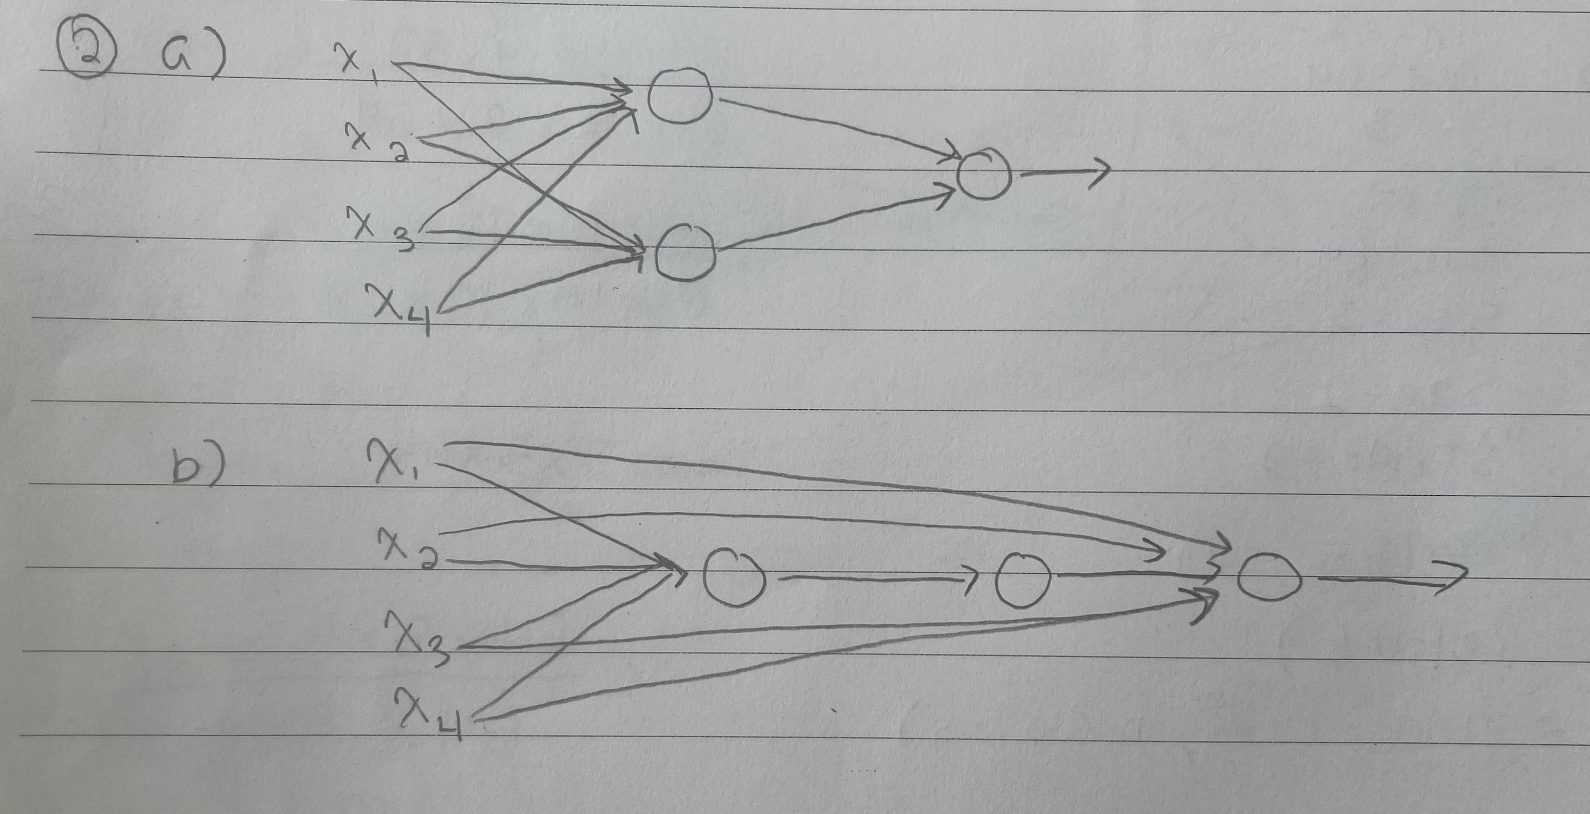

# 8.4 Logic Definition of Generalization:

##### a) Do Exercise 40.8 in MacKay’s book (MacKay 2003). It is cited here as follows:
Estimate in bits the total sensory experience that you have had in your life – visual information, auditory information, etc. Estimate how much information you have memorized. Estimate the information content of the works of Shakespeare. Compare these with the capacity of your brain assuming you have 1011 neurons each making 1000 synaptic connections and that the (information) capacity result for one neuron (two bits per connection) applies. Is your brain full yet?

Using the information found on this page for information transmission per second (https://www.britannica.com/science/information-theory/Physiology):

1. Visual: 10,000,000 per second:
$$
\text{Per Year} = 10,000,000 \times 31,536,000 = 315.36   \text{ TB/year} $$
$$

2. Skin: 1,000,000 per second:
$$
\text{Per Year} = 1,000,000 \times 31,536,000 = 31.536 \text{ TB/year} 
$$

3. Auditory: 100,000 per second:
$$
\text{Per Year} = 100,000 \times 31,536,000 = 3.1536\text{ TB/year} 
$$

5. Taste: 1,000 per second:
$$
\text{Per Year} = 1,000 \times 31,536,000 = 0.031536\text{ TB/year} 
$$

**Total per year** $$350.081136 \text { TB}$$

I'm 27 years old, so multiplying that out gives me $$1.04×10^{16} \text {bits experienced in my lifetime}$$


Assuming (generously) about 20% is stored in memory, then we have: $$2.08 × 10^{15} \text { bits memorized}$$

Using this information for Shakespeare (https://nlp.stanford.edu/IR-book/html/htmledition/an-example-information-retrieval-problem-1.html). If the size of the collected works is about 1M words and we can assume 6 bytes per word, 6MB total.

Total for the brain:
$$
\text 10^{11} \times 10^{3} \times 2 = 10^{11+3} \times 2 = 10^{14} \times 2 = 200×10 
^{12} \text{ bits}
$$

While my total sensory experience is far more than Shakespeare, my brain is far from full.

##### b) Expand Algorithm 8 to work with more than one binary classification.
The output of algorithm 8 with multi class classification is c/c-1 as stated in Law 5.1. We can confirm this with our outputs from section 6.2b, changing to a random dataset with c equi-distributed target classes. The clauses correspond to the thresholds, whereas the accuracy relates to the number of instances memorized. We divide the number of thresholds generated by the number of instances memorized.

In [32]:
num_points = 1000
num_classes = 3

X = np.random.rand(num_points, 2)
y = np.array([i % num_classes for i in range(num_points)])
predictions, accuracy, clauses = predict_if_then(X, y)

len(clauses)/(len(X)*accuracy) # Compare to 3/2 = 1.5

1.4857142857142858

##### c) Expand Algorithm 8 to work with regression.
As regression is essentially an infinite number of classes, c/c-1 tends to 1. Realistically, we expect more thresholds and less memorization the more points we add, hence the number of thresholds/memorization should increase. We can check using the same tactic as in part b, but with increasing numbers of classes.

In [28]:
num_points = 1000
num_classes = 100

X = np.random.rand(num_points, 10)
y = np.array([i % num_classes for i in range(num_points)])

predictions, accuracy, clauses = predict_if_then(X, y)

len(clauses)/(len(X)*accuracy)

33.77142857142857

In [29]:
num_points = 1000
num_classes = 200

X = np.random.rand(num_points, 10)
y = np.array([i % num_classes for i in range(num_points)])

predictions, accuracy, clauses = predict_if_then(X, y)

len(clauses)/(len(X)*accuracy) #Should be higher

119.8